In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import torch

from helper.painter import Painter
from helper.trainer import Trainer
from helper.data_generator import DataGenerator
from helper.loader import Loader
from helper.cond_encoder import CLIPEncoder

from auto_encoder.models.variational_auto_encoder import VariationalAutoEncoder
from clip.models.ko_clip import KoCLIPWrapper
from diffusion_model.sampler.ddim import DDIM
from diffusion_model.models.latent_diffusion_model import DiffusionModel
from diffusion_model.network.unet import Unet
from diffusion_model.network.unet_wrapper import UnetWrapper

/nfs/hpc/share/vuonga2/conda-env/diff/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import tqdm
from helper.util import extract
import matplotlib.pyplot as plt

In [3]:
# Path to the configuration file
CONFIG_PATH = './configs/cifar10_config.yaml'


# Set device
device = torch.device('cuda')

# Instantiate helper classes
painter = Painter()
loader = Loader()
data_generator = DataGenerator()

# Load CIFAR-10 dataset
data_loader = data_generator.cifar10(batch_size=2)

In [4]:

sampler = DDIM(CONFIG_PATH)  # Initialize the DDIM sampler
network = UnetWrapper(Unet, CONFIG_PATH, None)  # Initialize the U-Net network
dm = DiffusionModel(network, sampler, [3,32,32])  # Initialize the LDM

In [5]:
dm = loader.model_load('models/cifar10/dm', dm, is_ema=True)

Epoch: 707
Training step: 34643
Best loss: 0.017362909505561908
Batch size: 1024
Number of batches: 49
===Model loaded!===


50it [00:00, 84.22it/s] 


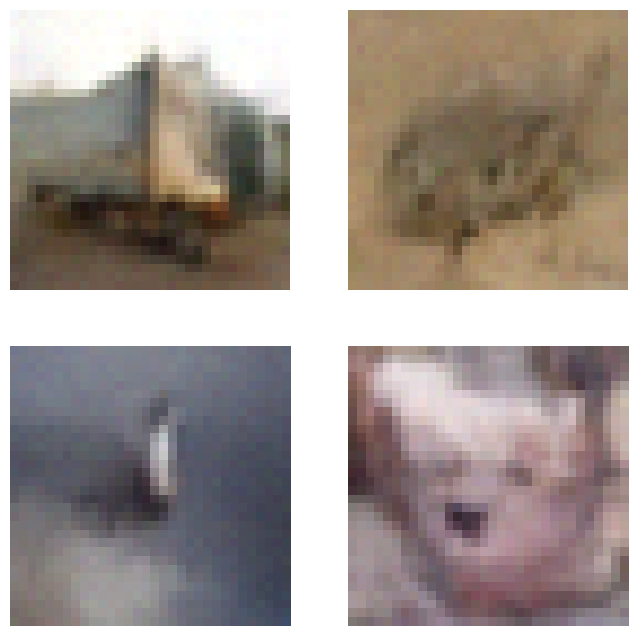

In [6]:
# Generate samples using the trained latent diffusion model
dm.eval()
dm = dm.to(device)
sample = dm.forward(n_samples=4)  # Generate 4 sample images, 'y' represents any conditions, 'gamma' means guidance scale
painter.show_images(sample)

In [7]:
sampler=sampler.to(device)
dm = dm.to(device)

sampler.eval()
dm.eval()

DiffusionModel(
  (sampler): DDIM(
    (network): UnetWrapper(
      (network): Unet(
        (init_conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (time_mlp): Sequential(
          (0): SinusoidalEmbedding()
          (1): Linear(in_features=64, out_features=256, bias=True)
          (2): GELU(approximate='none')
          (3): Linear(in_features=256, out_features=256, bias=True)
        )
        (downs): ModuleList(
          (0): ModuleList(
            (0-1): 2 x ResnetBlock(
              (block1): Block(
                (norm): AdaptiveGroupNorm(
                  (norm): GroupNorm(32, 64, eps=1e-05, affine=False)
                  (gamma_proj): Linear(in_features=256, out_features=64, bias=True)
                  (beta_proj): Linear(in_features=256, out_features=64, bias=True)
                )
                (proj): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (act): SiLU()
                (dropout): Dropout

In [8]:
sqrt_one_minus_alphas_cumprod = 1-sampler.alpha_bar

In [9]:
import torch.nn.functional as F
from torch.func import vmap, jvp

def f_only_x_one(x1, t1):
    # x1: (1,1,H,W); t1: (1,) or scalar-like
    t1b = t1.view(1)
    # denom = sqrt_one_minus_alphas_cumprod[t1b.long()].reshape(1,1,1,1).detach()
    return dm.network(x1, t1b.long())   # -> (1,1,H,W)

def f_flat_one(x1, t1):
    return f_only_x_one(x1, t1).reshape(-1)     # -> (N=H*W,)

# per-sample sub-Jacobian on the SAME input/output indices
def subjac_one_sample_same_points(x1, t1, idxs1, chunk=None):
    """
    x1:    (1,1,H,W)            single sample
    t1:    (1,)                 single timestep
    idxs1: (K,)                 same set for input & output
    chunk: int or None          optional micro-batch over K

    returns: J_sub (K,K), diag (K,)
    """
    N = x1.numel()                       # = H*W (since C=1)
    K = idxs1.numel()

    def jvp_one(v_i):
        # returns J v_i (shape N,)
        return jvp(lambda z: f_flat_one(z, t1), (x1,), (v_i,))[1]

    if chunk is None:
        V = F.one_hot(idxs1, num_classes=N).to(x1).view(K, *x1.shape)   # (K,1,1,H,W)
        Jvs = vmap(jvp_one)(V)                                          # (K, N)
    else:
        parts = []
        for part in idxs1.split(chunk):
            Vp = F.one_hot(part, num_classes=N).to(x1).view(-1, *x1.shape)
            parts.append(vmap(jvp_one)(Vp))                              # (c, N)
        Jvs = torch.cat(parts, dim=0)                                    # (K, N)

    J_sub = Jvs[:, idxs1].T.contiguous()                                 # (K, K)
    diag  = Jvs[torch.arange(K, device=x1.device), idxs1].contiguous()   # (K,)
    return J_sub, diag

# batch wrapper: loop over B in Python (no vmap over batch)
def subjac_batch_same_points(x, t, idxs_flat, per_sample=False, chunk=None):
    """
    x:          (B,1,H,W)
    t:          (B,)
    idxs_flat:  (K,) if per_sample=False (shared points across batch)
                (B,K) if per_sample=True  (different points per sample)
    returns: J_sub (B,K,K), diag (B,K)
    """
    B = x.size(0)
    J_list, d_list = [], []
    for b in range(B):
        idxs_b = idxs_flat[b] if per_sample else idxs_flat
        Jb, db = subjac_one_sample_same_points(x[b:b+1], t[b:b+1], idxs_b, chunk=chunk)
        J_list.append(Jb)
        d_list.append(db)
    return torch.stack(J_list, dim=0), torch.stack(d_list, dim=0)

In [ ]:
N_sim = 1000
skip = 10
Js = []
batch_size = 4
C, H, W = 3, 32, 32
K = 64
pbar = tqdm.tqdm(range(1, N_sim, skip))
for t_in in pbar:
    Js_tmp = []
    # reset data
    data_loader = data_generator.cifar10(batch_size=batch_size, shuffle=False)
    for idx, (x0, _) in enumerate(data_loader):
        pbar.set_description(f"batch {idx}")
        if idx >= 32: # collect from 128 images only
            break
        x0 = x0.to(device)
        
        t = torch.ones(batch_size,).long().to(device)*t_in
        x0_noised = sampler.q_sample(x0, t)
        
        # get scores & jacobian
        
        idxs_per = torch.stack([torch.randperm(C*H*W, device=x0_noised.device)[:K] for _ in range(batch_size)], dim=0)
        J_sub, _ = subjac_batch_same_points(x0_noised, t, idxs_per, per_sample=True, chunk=16) # (batch, 64, 64)
        
        Js_tmp.append(J_sub.detach().cpu().numpy())
    Js.append(np.vstack(Js_tmp))

np.save(f'stats/jacobian_t{N_sim}', np.array(Js))

batch 14:   0%|          | 0/100 [00:12<?, ?it/s]